# 5. Sequence Analysis

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

## 5.1 ARIMA

In [2]:
all_data = pd.read_parquet('all_data_for_regression.parquet')

In [3]:
# sort the data by series_id and step
all_data_sorted = all_data.sort_values(by=['series_id', 'step'])

all_data_sorted.head()

,series_id,step,timestamp,anglez,enmo,hour,event,night,sleep_duration,anglez_diff,...,enmo_rolling_mean,anglez_rolling_max,enmo_rolling_max,anglez_rolling_std,enmo_rolling_std,anglez_diff_rolling_mean,enmo_diff_rolling_mean,anglez_diff_rolling_max,enmo_diff_rolling_max,enmo_rolling_skew
0,0,0,2018-11-05 10:00:00,30.845301,0.0447,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
1,0,1,2018-11-05 10:00:05,34.181801,0.0443,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
2,0,2,2018-11-05 10:00:10,33.877102,0.0483,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
3,0,3,2018-11-05 10:00:15,34.282101,0.0680,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
4,0,4,2018-11-05 10:00:20,34.385799,0.0768,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953


In [4]:
# check the stationarity of the data
min_missing_ratio = float('inf')
series_id_with_min_missing_ratio = None

# check continuous series_id
for series_id in all_data_sorted['series_id'].unique():
    series_data = all_data_sorted[all_data_sorted['series_id'] == series_id]
    series_data = series_data.sort_values(by='step') 

    # calculate total steps
    total_steps = len(series_data)

    # find missing steps count
    step_diff = series_data['step'].diff() - 1
    missing_steps_count = step_diff[step_diff > 0].sum()

    # calculate missing ratio
    missing_ratio = missing_steps_count / total_steps if total_steps > 0 else 0

    # update min_missing_ratio and series_id_with_min_missing_ratio
    if missing_ratio < min_missing_ratio:
        min_missing_ratio = missing_ratio
        series_id_with_min_missing_ratio = series_id

print(f"The series_id with the smallest percentage of total step is {series_id_with_min_missing_ratio},missing ratio is {min_missing_ratio:.2%}")


The series_id with the smallest percentage of total step is 0,missing ratio is 0.00%


In [5]:
# Look at when the event column is 0 for data with a series_id of 0
all_data_sorted[all_data_sorted['series_id'] == 0]['event'].value_counts()

1.0    303384
0.0    136896
Name: event, dtype: int64

In [6]:
# Look at when the event column is 1 for data with a series_id of 0
all_data_sorted[all_data_sorted['series_id'] == 0].tail(1)['step']

440279    440279
Name: step, dtype: uint32

In [7]:
all_data_sorted.head()

,series_id,step,timestamp,anglez,enmo,hour,event,night,sleep_duration,anglez_diff,...,enmo_rolling_mean,anglez_rolling_max,enmo_rolling_max,anglez_rolling_std,enmo_rolling_std,anglez_diff_rolling_mean,enmo_diff_rolling_mean,anglez_diff_rolling_max,enmo_diff_rolling_max,enmo_rolling_skew
0,0,0,2018-11-05 10:00:00,30.845301,0.0447,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
1,0,1,2018-11-05 10:00:05,34.181801,0.0443,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
2,0,2,2018-11-05 10:00:10,33.877102,0.0483,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
3,0,3,2018-11-05 10:00:15,34.282101,0.0680,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953
4,0,4,2018-11-05 10:00:20,34.385799,0.0768,10,0.0,1.0,3.333333,-9.125,...,0.074097,34.9375,0.197998,3.712891,0.031433,-9.125,0.017502,-9.125,0.017502,1.876953


In [8]:
# Setting the timestamp column as a time series index
if 'timestamp' in all_data_sorted.columns:
    all_data_sorted = all_data_sorted.set_index('timestamp')

# choose series_id = 0 to analyze
selected_series_id = all_data_sorted[all_data_sorted['series_id'] == 0]

# ADF test to check the stationarity of the data
result = adfuller(selected_series_id['event'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -7.620286888674906
p-value: 2.1374348425170087e-11


ADF Test: -7.620286888674906 is a negative value and a larger absolute value, so we can reject the null hypothesis with a significance level of 0.05. The data is stationary.

p-value: 2.1374348425170087e-11 (p < 0.05) means that the data is stationary.


Visualization

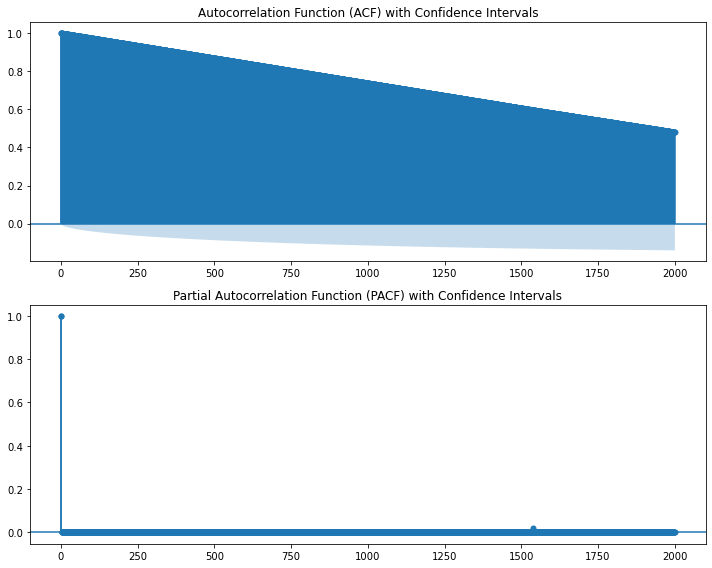

In [9]:
# ACF and PACF plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# ACF plot
plot_acf(selected_series_id['event'].dropna(), lags=2000, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) with Confidence Intervals')
axes[0].xlim = (0, 2)

# PACF plot
plot_pacf(selected_series_id['event'].dropna(), lags=2000, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) with Confidence Intervals')
axes[1].xlim = (0, 2)

plt.tight_layout()
plt.show()

The figure shows the ACF and PACF of the data.

The ACF value decreases gradually from 1 and at 2000 steps the value is about 0.6. This indicates that there is some degree of autocorrelation in the sequence, but the autocorrelation diminishes as the delay increases.

The PACF is 1 at 0, and after that the value is basically around 0, but there is a slightly noticeable bump at about 1500 steps. This usually indicates that there may be a larger order in the AR model.

ARIMA Model

In [38]:
train = selected_series_id[:-60]
test = selected_series_id[-60:]

In [58]:
# train the ARIMA model
model = ARIMA(train['event'].dropna(), order=(1, 0, 1))
model_fit = model.fit()

# predict 
predictions = model_fit.forecast(steps=120) 

print(predictions)

2018-11-30 21:25:00    0.999919
2018-11-30 21:25:05    0.999837
2018-11-30 21:25:10    0.999756
2018-11-30 21:25:15    0.999674
2018-11-30 21:25:20    0.999593
                         ...   
2018-11-30 21:34:35    0.990696
2018-11-30 21:34:40    0.990617
2018-11-30 21:34:45    0.990538
2018-11-30 21:34:50    0.990460
2018-11-30 21:34:55    0.990381
Freq: 5S, Name: predicted_mean, Length: 120, dtype: float64


How to choose p,d and q value?

p: The value of p is determined by the PACF diagram. The value of p is the number of significant lags in the PACF diagram. In this case, the value of p is 1.

d: The value of d is determined by the number of times the sequence is differentiated to make the sequence stationary. In this case, the value of d is 1.

q: The value of q is determined by the ACF diagram. The value of q is the number of significant lags in the ACF diagram. In this case, the value of q is 1. Maybe 2 is better.

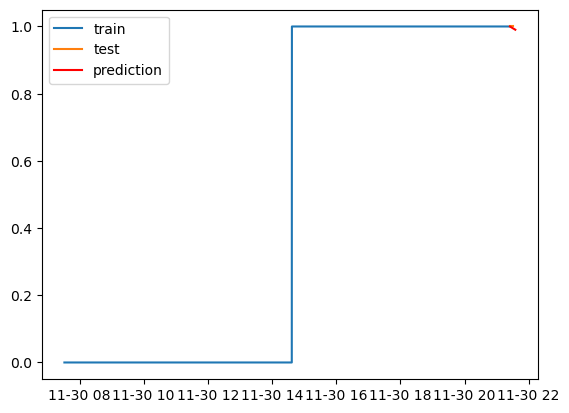

In [60]:
# plot the prediction
plt.plot(train['event'].dropna().tail(10000), label='train')
plt.plot(test['event'].dropna(), label='test')
plt.plot(predictions, color='red', label='prediction')
plt.legend()
plt.show()

In [61]:
# evaluate the model
mse = mean_squared_error(test['event'], predictions[60:])

print('Mean Squared Error:', mse)

Mean Squared Error: 5.488654634373955e-05


Why we split the data into training and testing?

The testing data is the last 12 steps (1min) of the data. And we want to use train data to predict the last 12 steps and the future 12 steps. Then use testing data to compare the prediction with the real data and calculate MSE.

And we can see the ARIMA output is slowly decreased. Because the dataset is so large so I only output the 1min future prediction. If the prediction step is larger, the output will be more smooth and finally go to 0 (which means next onset stage). So I think the ARIMA model is suitable for this dataset (based on the MSE), but only seen the output we may think it is not that suitable.


Single variable time series prediction: only use past events to predict future events